In [ ]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import numpy as np

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
%matplotlib inline
import sklearn.metrics
import seaborn as sns
import random

In [ ]:
# Customized transform (transforms to tensor, here you can normalize, perform Data Augmentation etc.)
my_transform = transforms.Compose([transforms.ToTensor()])

# Download data
mnist_train = torchvision.datasets.MNIST('data', train = True, download=True, transform=my_transform)
mnist_test = torchvision.datasets.MNIST('data', train = False, download=True, transform=my_transform)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
x_train, x_val = train_test_split(mnist_train, test_size=10000, random_state=122)

In [ ]:
# The Neural Network
class VanillaRNN_MNIST(nn.Module):
    def __init__(self, batch_size, input_size, hidden_size, output_size):
        super(VanillaRNN_MNIST, self).__init__()
        self.batch_size, self.input_size, self.hidden_size, self.output_size = batch_size, input_size, hidden_size, output_size
        
        # RNN Layer
        self.rnn = nn.RNN(input_size, hidden_size)
        # Fully Connected Layer
        self.layer = nn.Linear(hidden_size, self.output_size)
    
    def forward(self, images, prints=False):
        if prints: print('Original Images Shape:', images.shape)
        
        images = images.permute(1, 0, 2)
        if prints: print('Permuted Imaged Shape:', images.shape)
        
        # Initialize hidden state with zeros
        hidden_state = torch.zeros(1, self.batch_size, self.hidden_size)
        if prints: print('Initial hidden state Shape:', hidden_state.shape)
        
        # Creating RNN
        hidden_outputs, hidden_state = self.rnn(images, hidden_state)
        
        # Log probabilities
        out = self.layer(hidden_state)
        
        if prints:
            print('----hidden_outputs shape:', hidden_outputs.shape, '\n' +
                  '----final hidden state:', hidden_state.shape, '\n' +
                  '----out shape:', out.shape)
        
        # Reshaped out
        out = out.view(-1, self.output_size)
        if prints: print('Out Final Shape:', out.shape)
        
        return out


In [ ]:
# ==== STATICS ====
batch_size = 64        # how many images to be trained in one iteration
input_size = 28        # image 28 by 28
hidden_size = 150      # can be changed to any number: neurons
output_size = 10       # 10 different digits
# =================

In [ ]:
# Create a train_loader to select a batch from it
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=10)

# Select one full batch from the data
images_example, labels_example = next(iter(train_loader))
print('original images shape:', images_example.shape)

# Reshape
images_example = images_example.view(-1, 28, 28)
print('changed images shape:', images_example.shape)
print('labels shape:', labels_example.shape, '\n')

# Creating the model
model_example = VanillaRNN_MNIST(batch_size, input_size, hidden_size, output_size)


out = model_example(images_example, prints=True)

In [ ]:
# Understand Model Parameters
print('Len parameters:', len(list(model_example.parameters())), '\n' +
      'Parameters 0 - U:', list(model_example.parameters())[0].shape, '\n' +
      'Parameters 1 - W:', list(model_example.parameters())[1].shape, '\n' +
      'Parameters 2 - Bias:', list(model_example.parameters())[2].shape, '\n' +
      'Parameters 3 - Bias:', list(model_example.parameters())[3].shape, '\n' +
      'Parameters 4 - FNN weights:', list(model_example.parameters())[4].shape, '\n' +
      'Parameters 5 - Predictions:', list(model_example.parameters())[5].shape)

Len parameters: 6 
Parameters 0 - U: torch.Size([150, 28]) 
Parameters 1 - W: torch.Size([150, 150]) 
Parameters 2 - Bias: torch.Size([150]) 
Parameters 3 - Bias: torch.Size([150]) 
Parameters 4 - FNN weights: torch.Size([10, 150]) 
Parameters 5 - Predictions: torch.Size([10])


In [ ]:
def get_accuracy(out, actual_labels, batchSize):
    '''Saves the Accuracy of the batch.
    Takes in the log probabilities, actual label and the batchSize (to average the score).'''
    predictions = out.max(dim=1)[1]
    correct = (predictions == actual_labels).sum().item()
    accuracy = correct/batch_size
    #plt.plot(accuracy)

    return accuracy

In [ ]:
def train_network(model, train_data, test_data, batchSize=64, num_epochs=1, learning_rate=0.001):
    
    '''Trains the model and computes the average accuracy for train and test data.'''
    
    print('Get data ready...')
    # Create dataloader for training dataset - so we can train on multiple batches
    # Shuffle after every epoch
    train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batchSize, shuffle=True, drop_last=True)
    test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=batchSize, shuffle=True, drop_last=True)
    
    # Create criterion and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    
    print('Training started...')
    # Train the data multiple times
    for epoch in range(num_epochs):
        
        # Save Train and Test Loss
        train_loss = 0
        train_acc = 0
        los=[]
        
        # Set model in training mode:
        hist=model.train()
        
        for k, (images, labels) in enumerate(train_loader):
            
            # Get rid of the channel
            images = images.view(-1, 28, 28)
            
            # Create log probabilities
            out = model(images)
            # Clears the gradients from previous iteration
            optimizer.zero_grad()
            # Computes loss: how far is the prediction from the actual?
            loss = criterion(out, labels)
            # Computes gradients for neurons
            loss.backward()
            # Updates the weights
            optimizer.step()
            
            # Save Loss & Accuracy after each iteration
            train_loss += loss.item()
            train_acc += get_accuracy(out, labels, batchSize)
            #los.append(train_loss)
            #plt.plot(los)
        
        # Print Average Train Loss & Accuracy after each epoch
        print('TRAIN | Epoch: {}/{} | Loss: {:.2f} | Accuracy: {:.2f}'.format(epoch+1, num_epochs, train_loss/k, train_acc/k))
         

    print('Testing Started...')
    # Save Test Accuracy
    test_acc = 0
    # Evaluation mode
    model.eval()
    
    for k, (images, labels) in enumerate(test_loader):
        # Get rid of the channel
        images = images.view(-1, 28, 28)
        
        # Create logit predictions
        out = model(images)
        # Add Accuracy of this batch
        test_acc += get_accuracy(out, labels, batchSize)
        
    # Print Final Test Accuracy
    print('TEST | Average Accuracy per {} Loaders: {:.5f}'.format(k, test_acc/k) )
    #return los

In [ ]:
# ==== STATICS ====
batch_size=64
input_size=28
hidden_size=150
output_size=10

# Instantiate the model
vanilla_rnn = VanillaRNN_MNIST(batch_size, input_size, hidden_size, output_size)

# ==== TRAIN ====
hist0=train_network(vanilla_rnn, x_train, mnist_test, num_epochs=20)

Get data ready...
Training started...
TRAIN | Epoch: 1/20 | Loss: 0.74 | Accuracy: 0.76
TRAIN | Epoch: 2/20 | Loss: 0.30 | Accuracy: 0.91
TRAIN | Epoch: 3/20 | Loss: 0.22 | Accuracy: 0.94
TRAIN | Epoch: 4/20 | Loss: 0.19 | Accuracy: 0.95
TRAIN | Epoch: 5/20 | Loss: 0.17 | Accuracy: 0.95
TRAIN | Epoch: 6/20 | Loss: 0.16 | Accuracy: 0.96
TRAIN | Epoch: 7/20 | Loss: 0.14 | Accuracy: 0.96
TRAIN | Epoch: 8/20 | Loss: 0.13 | Accuracy: 0.96
TRAIN | Epoch: 9/20 | Loss: 0.13 | Accuracy: 0.96
TRAIN | Epoch: 10/20 | Loss: 0.12 | Accuracy: 0.97
TRAIN | Epoch: 11/20 | Loss: 0.12 | Accuracy: 0.97
TRAIN | Epoch: 12/20 | Loss: 0.11 | Accuracy: 0.97
TRAIN | Epoch: 13/20 | Loss: 0.10 | Accuracy: 0.97
TRAIN | Epoch: 14/20 | Loss: 0.10 | Accuracy: 0.97
TRAIN | Epoch: 15/20 | Loss: 0.10 | Accuracy: 0.97
TRAIN | Epoch: 16/20 | Loss: 0.09 | Accuracy: 0.97
TRAIN | Epoch: 17/20 | Loss: 0.09 | Accuracy: 0.98
TRAIN | Epoch: 18/20 | Loss: 0.09 | Accuracy: 0.97
TRAIN | Epoch: 19/20 | Loss: 0.09 | Accuracy: 0.98
TR

Text(0.5, 1.0, 'train accuracy for batch_size=100 and hidden layer neurons= 150')

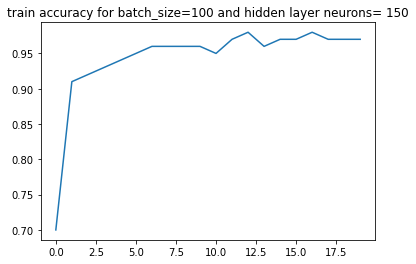

In [ ]:
plt.plot(acc_train)
plt.title('train accuracy for batch_size=100 and hidden layer neurons= 150')

Text(0.5, 1.0, 'train loss for batch_size=100 and hidden layer neurons= 150')

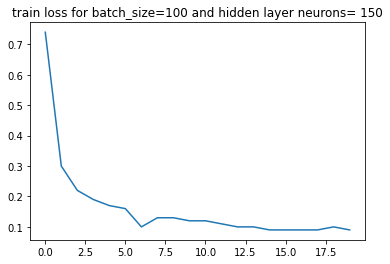

In [ ]:
plt.plot(loss_train)
plt.title('train loss for batch_size=100 and hidden layer neurons= 150')

Text(0.5, 1.0, 'validation loss for batch_size=100 and hidden layer neurons= 150')

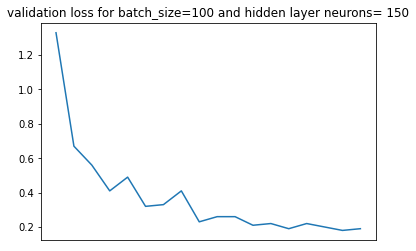

In [ ]:
plt.plot(loss_validation)
plt.xticks([])
plt.title('validation loss for batch_size=100 and hidden layer neurons= 150')

Text(0.5, 1.0, 'validation accuracy for batch_size=100 and hidden layer neurons= 150')

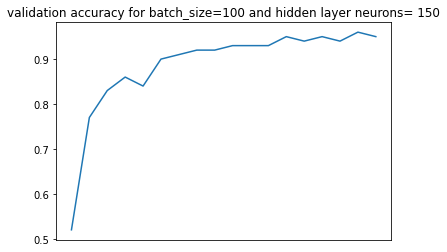

In [ ]:
plt.plot(acc_val)
plt.xticks([])
plt.title('validation accuracy for batch_size=100 and hidden layer neurons= 150')

Q-2

In [ ]:
import torch
from torch import Tensor
from torch import nn
import numpy as np
import argparse
import os
import matplotlib.pyplot as plt

#parser = argparse.ArgumentParser()
#parser.add_argument("--H", type = int, default =5 ,help = "Hidden length")
#args = parser.parse_args()

LR = 0.01
EPOCH = 15
ITER = 100
ITER_EVAL = 20
batch = 64

HIDDEN = 3

acc = []
ll = []

def gen_seq(L, batch = 1, i=1):
    '''
    Generate a sequence of 0-10, length L.
    And output as an index (default 0)
    Return as [batch, L, 10]; [batch, 10]
    '''
    d = np.random.randint(low= 0, high = 9, size = (batch, L))

    x = np.zeros((batch, L,10))
    for b in range(batch):
        x[b,np.arange(L), d[b]] = 1
    
    # x[np.arange(L), d] = 1

    d = torch.tensor(d, dtype=torch.int)
    x = torch.tensor(x, dtype=torch.int)

    y_o = d[:,i]
    y = np.zeros((batch,10))

    for b in range(batch):
        y[b,y_o[b]] = 1

    y = torch.tensor(y, dtype=torch.int)

    return d,x,y_o,y


class LSTM(nn.Module):
    def __init__(self, input_size = 10,
            hidden_size = HIDDEN):
        super(LSTM, self).__init__()

        self.lstm = nn.LSTM(         # if use nn.RNN(), it hardly learns
            input_size=input_size,
            hidden_size=hidden_size,         # rnn hidden unit
            num_layers=1,           # number of rnn layer
            batch_first=True,       # input & output will has batch size as 1s dimension. e.g. (batch, time_step, input_size)
        )

        self.out = nn.Linear(hidden_size, 10)

    def forward(self, x):
        # x shape (batch, time_step, input_size)
        # r_out shape (batch, time_step, output_size)
        # h_n shape (n_layers, batch, hidden_size)
        # h_c shape (n_layers, batch, hidden_size)
        r_out, (h_n, h_c) = self.lstm(x, None)   # None represents zero initial hidden state

        # choose r_out at the last time step
        out = self.out(r_out[:, -1, :])
        return out

rnn = LSTM()
print(rnn)

optimizer = torch.optim.Adam(rnn.parameters(), lr=LR)   # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()                       # the target label is not one-hotted

# training and testing
for epoch in range(EPOCH):
    print(f"\n\n----\n\nEpoch {epoch}")
    train_accuracy = 0

    for i in range(ITER):
        L = np.random.randint(low = 3, high = 10)
        
        d,b_x,y_o, b_y = gen_seq(L, batch = batch)

        b_x = b_x.view(batch, L, 10)              # reshape x to (batch, time_step, input_size)
        b_x = b_x.float()
        y_o = y_o.long()

        output = rnn(b_x)                               # rnn output
        
        loss = loss_func(output, y_o)                   # cross entropy loss
        if i % 500 == 0:
            print(f"Epoch {epoch} Step {i}")
            print(f"Loss is {loss}")
        optimizer.zero_grad()                           # clear gradients for this training step
        loss.backward()                                 # backpropagation, compute gradients
        optimizer.step()                                # apply gradients

        pred_y = torch.max(output, 1)[1].data.numpy().squeeze()
        train_accuracy += np.sum(pred_y == y_o.numpy()).sum()

    train_accuracy = float(train_accuracy)/(ITER * batch)
    ll.append(loss)
    test_accuracy = 0

    for i in range(ITER_EVAL):
        L = np.random.randint(low = 3, high = 10)
        
        d,b_x,y_o, b_y = gen_seq(L, batch = batch)

        b_x = b_x.view(batch, L, 10)              # reshape x to (batch, time_step, input_size)
        b_x = b_x.float()
        y_o = y_o.long()

        output = rnn(b_x)                               # rnn output
        
        loss = loss_func(output, y_o)                   # cross entropy loss

        pred_y = torch.max(output, 1)[1].data.numpy().squeeze()
        test_accuracy += np.sum(pred_y == y_o.numpy())
       

    test_accuracy = float(test_accuracy)/(ITER_EVAL * batch)
    acc.append(test_accuracy)
    print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.numpy(), 
    '| train accuracy: %.4f' % train_accuracy, '| test accuracy: %.4f' % test_accuracy)


L = np.random.randint(low = 3, high = 10)
d,b_x,y_o, b_y = gen_seq(L, batch = 1)

b_x = b_x.view(1, L, 10)              # reshape x to (batch, time_step, input_size)
b_x = b_x.float()
y_o = y_o.long()

output = rnn(b_x)                               # rnn output

loss = loss_func(output, y_o)                   # cross entropy loss

pred_y = torch.max(output, 1)[1].data.numpy().squeeze()
print(f"Input Sequence {d}")
print(f"Truth {y_o}")
print(f"Prediction {pred_y}")

LSTM(
  (lstm): LSTM(10, 3, batch_first=True)
  (out): Linear(in_features=3, out_features=10, bias=True)
)


----

Epoch 0
Epoch 0 Step 0
Loss is 2.3064894676208496
Epoch:  0 | train loss: 2.0910 | train accuracy: 0.1308 | test accuracy: 0.1750


----

Epoch 1
Epoch 1 Step 0
Loss is 2.1558902263641357
Epoch:  1 | train loss: 2.0324 | train accuracy: 0.1669 | test accuracy: 0.1969


----

Epoch 2
Epoch 2 Step 0
Loss is 2.0600271224975586
Epoch:  2 | train loss: 1.6999 | train accuracy: 0.2025 | test accuracy: 0.2188


----

Epoch 3
Epoch 3 Step 0
Loss is 1.7897944450378418
Epoch:  3 | train loss: 1.5734 | train accuracy: 0.2261 | test accuracy: 0.1977


----

Epoch 4
Epoch 4 Step 0
Loss is 1.5658928155899048
Epoch:  4 | train loss: 1.5172 | train accuracy: 0.2280 | test accuracy: 0.2266


----

Epoch 5
Epoch 5 Step 0
Loss is 1.5704376697540283
Epoch:  5 | train loss: 1.5476 | train accuracy: 0.2266 | test accuracy: 0.2281


----

Epoch 6
Epoch 6 Step 0
Loss is 1.5302071571350098
Epoch: 

mse vs ce

LSTM(
  (lstm): LSTM(2, 3, batch_first=True)
  (out): Linear(in_features=3, out_features=1, bias=True)
)


----

Epoch 0
Epoch 0 Step 0
Loss is 0.24939116835594177
0.0
895


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 0 Step 500
Loss is 0.044132646173238754
638.0
638
Epoch:  0 | train loss: 0.0435 | train loss: 0.0566 | train accuracy: 0.4783 | test accuracy: 0.5859


----

Epoch 1
Epoch 1 Step 0
Loss is 0.03833832964301109
57.0
57
Epoch 1 Step 500
Loss is 0.0501541942358017
120.0
126
Epoch:  1 | train loss: 0.0535 | train loss: 0.0576 | train accuracy: 0.5776 | test accuracy: 0.5875


----

Epoch 2
Epoch 2 Step 0
Loss is 0.05752744525671005
568.0
570
Epoch 2 Step 500
Loss is 0.03410572186112404
1009.0
1009
Epoch:  2 | train loss: 0.0548 | train loss: 0.0480 | train accuracy: 0.5762 | test accuracy: 0.6250


----

Epoch 3
Epoch 3 Step 0
Loss is 0.044225119054317474
384.0
392
Epoch 3 Step 500
Loss is 0.044732529670000076
552.0
552
Epoch:  3 | train loss: 0.0362 | train loss: 0.0457 | train accuracy: 0.5735 | test accuracy: 0.5563


----

Epoch 4
Epoch 4 Step 0
Loss is 0.058228470385074615
981.0
981
Epoch 4 Step 500
Loss is 0.04534417763352394
80.0
80
Epoch:  4 | train loss: 0.0451 | train loss:

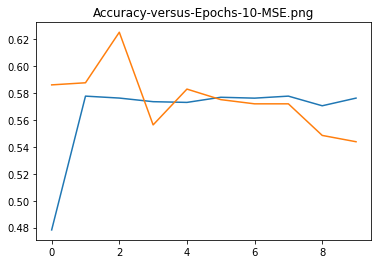

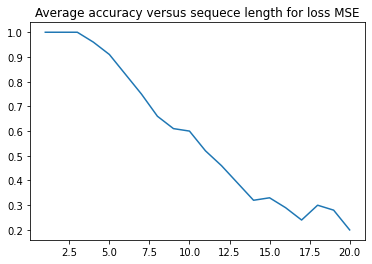

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
import argparse
import os
import matplotlib.pyplot as plt



LR = 0.01
EPOCH = 10
ITER = 1000
ITER_EVAL = 20
batch = 32

HIDDEN = 3

L = 10

loss_type = 'MSE' # Or CE


def to_binary(x, L):
    '''
    Convert x to binary in reverse.
    x can go upto 2**L - 1
    size L + 1
    '''

    bin_x = str(bin(x))
    arr_x = np.array(list(bin_x[2:]), dtype = int)
    arr_x = arr_x[::-1]

    arr = np.zeros((L+1))
    arr[0: len(arr_x)] = arr_x

    return arr

def gen_seq(L, batch = 1):
    '''
    Generate a sequence of 0-10, length L.
    And output as an index (default 0)
    Return as [batch, L + 1, 2]; [batch, L + 1]
    '''

    x = np.zeros((batch, L + 1,2))
    y = np.zeros((batch, L + 1))

    for b_ in range(batch):

        c = np.random.randint(low = 0, high = 2**L )
        a = np.random.randint(low = 0, high = c + 1)
        b = c - a

        str_a = to_binary(a,L)
        str_b = to_binary(b,L)
        str_c = to_binary(c,L)

        x[b_, :, 0] = str_a 
        x[b_, : ,1] = str_b

        y[b_,:] = str_c
    
    x = torch.tensor(x, dtype=torch.int)
    y = torch.tensor(y, dtype=torch.int)

    return x,y


class LSTM(nn.Module):
    def __init__(self, input_size = 2,
            hidden_size = HIDDEN):
        super(LSTM, self).__init__()

        self.lstm = nn.LSTM(         # if use nn.RNN(), it hardly learns
            input_size=input_size,
            hidden_size=hidden_size,         # rnn hidden unit
            num_layers=1,           # number of rnn layer
            batch_first=True,       # input & output will has batch size as 1s dimension. e.g. (batch, time_step, input_size)
        )

        self.out = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # x shape (batch, time_step, input_size)
        # r_out shape (batch, time_step, output_size)
        # h_n shape (n_layers, batch, hidden_size)
        # h_c shape (n_layers, batch, hidden_size)
        r_out, (h_n, h_c) = self.lstm(x, None)   # None represents zero initial hidden state

        # choose r_out at the last time step
        # out = F.sigmoid(self.out(r_out[:, -1, :]))
        out = F.sigmoid(self.out(r_out))
        return out

rnn = LSTM()
print(rnn)

optimizer = torch.optim.Adam(rnn.parameters(), lr=LR)   # optimize all cnn parameters
if loss_type == "MSE":
    loss_func = nn.MSELoss()
else: 
    loss_func = nn.CrossEntropyLoss()                       # the target label is not one-hotted


train_acc = []
test_acc = []
train_ll = []
test_ll = []

# training and testing
for epoch in range(EPOCH):
    print(f"\n\n----\n\nEpoch {epoch}")
    train_accuracy = 0

    for i in range(ITER):
        
        b_x , b_y = gen_seq(L, batch = batch)

        # b_x = b_x.view(batch, L, 10)              # reshape x to (batch, time_step, input_size)
        b_x = b_x.float()
        b_y = b_y.long()

        output = rnn(b_x)                               # rnn output
        
        if loss_type != "MSE":
            b_y2 = b_y.numpy().copy()
            b_y2 = np.argmax(b_y2, axis=1)

            b_y2 = torch.Tensor(b_y2)

            b_y2 = b_y2.long()
        else:
            b_y2 = b_y.float()

        loss = loss_func(output[:,:,0], b_y2 )                  
        
        optimizer.zero_grad()                           # clear gradients for this training step
        loss.backward()                                 # backpropagation, compute gradients
        optimizer.step()                                # apply gradients

        t = torch.Tensor([0.5])
        pred_y = (output > t).float() * 1

        pred_y = pred_y.numpy()[:,:,0]
        pred_y = pred_y.dot(2**np.arange(pred_y.shape[1]))

        b_y = b_y.numpy()
        b_y = b_y.dot(2**np.arange(b_y.shape[1]))

        if i % 500 == 0:
            print(f"Epoch {epoch} Step {i}")
            print(f"Loss is {loss}")
            print(pred_y[0])
            print(b_y[0])

        train_accuracy += np.sum(pred_y == b_y)

    train_accuracy = float(train_accuracy)/(ITER * batch)
    train_ll.append(loss) 
    train_acc.append(train_accuracy)

    test_accuracy = 0

    for i in range(ITER_EVAL):
        
        b_x, b_y = gen_seq(L, batch = batch)

        # b_x = b_x.view(batch, L , 2)              # reshape x to (batch, time_step, input_size)
        b_x = b_x.float()
        b_y = b_y.long()

        output = rnn(b_x)                               # rnn output

        if loss_type != "MSE":
            b_y2 = b_y.numpy().copy()
            b_y2 = np.argmax(b_y2, axis=1)

            b_y2 = torch.Tensor(b_y2)

            b_y2 = b_y2.long()
        else:
            b_y2 = b_y.float()

        test_loss = loss_func(output[:,:,0], b_y2 )   
        
        t = torch.Tensor([0.5])
        pred_y = (output > t).float() * 1

        pred_y = pred_y.numpy()[:,:,0]
        pred_y = pred_y.dot(2**np.arange(pred_y.shape[1]))

        b_y = b_y.numpy()
        b_y = b_y.dot(2**np.arange(b_y.shape[1]))

        test_accuracy += np.sum(pred_y == b_y)

    test_accuracy = float(test_accuracy)/(ITER_EVAL * batch)

    test_ll.append(test_loss) 
    test_acc.append(test_accuracy)

    print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.numpy(), '| train loss: %.4f' % test_loss.data.numpy(),
    '| train accuracy: %.4f' % train_accuracy, '| test accuracy: %.4f' % test_accuracy)

# Average out error
av_acc = []
for t_L in range(1,21):

    b_x, b_y = gen_seq(t_L, batch = 100)

    b_x = b_x.float()
    b_y = b_y.long()

    output = rnn(b_x)                               # rnn output
    
    t = torch.Tensor([0.5])
    pred_y = (output > t).float() * 1

    pred_y = pred_y.numpy()[:,:,0]
    pred_y = pred_y.dot(2**np.arange(pred_y.shape[1]))

    b_y = b_y.numpy()
    b_y = b_y.dot(2**np.arange(b_y.shape[1]))

    test_accuracy = np.sum(pred_y == b_y)/ 100
    av_acc.append(test_accuracy)
    print(f"Average error | Length of seq {t_L} | test accuracy over 100 samples {test_accuracy}")

if not os.path.exists("logs"):
    os.mkdir("logs")

plt.plot(np.arange(EPOCH),train_acc, test_acc)
plt.title(f"Accuracy-versus-Epochs-{L}-{loss_type}.png")
plt.show()


plt.plot(np.arange(20)+1, av_acc)
plt.title(f"Average accuracy versus sequece length for loss {loss_type}")
plt.show()